# Solving the diffusion equation using PyTorch
We use a PyTorch tensor to store the grid and compute the output of the diffusione equation at the grid points. 
We write again the diffusion equation

$$ \frac{\partial u(x, t)}{\partial t} = D \nabla^2 u(x, t)$$

where D is the diffusion coefficient and $\nabla^2$ is the Laplacian operator.

In [1]:
import time
from functools import partial
import matplotlib.pyplot as plt
import torch
from torch import roll, zeros

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
GRID_SHAPE = (2048, 2048)

In [3]:
def timer(fxn, max_time=5):
    N = 0
    total_time = 0
    fxn()  # prime the pump
    while total_time < max_time:
        start = time.perf_counter()
        fxn()
        total_time += time.perf_counter() - start
        N += 1
    return total_time / N

In [4]:
def init_grid(grid_shape):
    grid = zeros(grid_shape)
    block_low = int(grid_shape[0] * 0.4)
    block_high = int(grid_shape[0] * 0.5)
    grid[block_low:block_high, block_low:block_high] = 0.005
    return grid

In [5]:
def laplacian(grid):
    return (
        roll(grid, +1, 0) +
        roll(grid, -1, 0) +
        roll(grid, +1, 1) +
        roll(grid, -1, 1) -
        4 * grid
    )

In [6]:
def evolve(grid, dt, D=1):
    return grid + dt * D * laplacian(grid)

In [7]:
def run_experiment(num_iterations, grid_shape=GRID_SHAPE, device=DEVICE):
    start_time = time.time()
    grid = init_grid(grid_shape)    
    for i in range(num_iterations):
        grid = evolve(grid, 0.1)
    exec_time = time.time() - start_time 
    return grid, exec_time

In [9]:
def debug_cpu_onboard(num_iterations, grid_shape=GRID_SHAPE, device=DEVICE):
    start_time = time.time()
    grid = init_grid(grid_shape)
    grid = grid.to(device)  # <3>
    for i in range(num_iterations):
        grid = evolve(grid, 0.1)
        torch.cuda.synchronize()
    exec_time = time.time() - start_time
    return grid, exec_time

In [10]:
def debug_cpu_copy(num_iterations, grid_shape=GRID_SHAPE, device=DEVICE):
    start_time = time.time()
    grid = init_grid(grid_shape)
    grid = grid.to(device)  # <3>
    for i in range(num_iterations):
        grid = evolve(grid, 0.1)
        grid.cpu()
    exec_time = time.time() - start_time
    return grid, exec_time

Execution time: 30.75 sec.
Execution time: 29.97 sec.


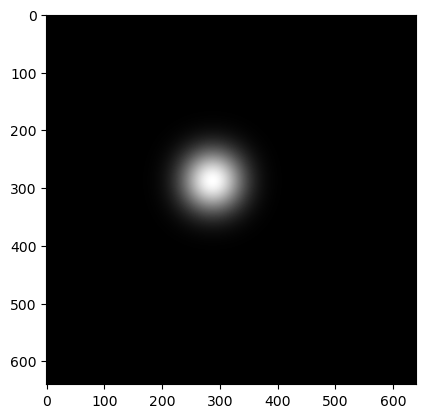

In [12]:
if __name__ == "__main__":
    grid_shape = (640, 640)
    num_iterations = 5000
    diffuse_grid, exec_time = run_experiment(num_iterations, grid_shape=grid_shape)
    print('Execution time: {:.2f} sec.'.format(exec_time))
    #diffuse_grid, exec_time = debug_cpu_onboard(num_iterations, grid_shape=grid_shape)
    #print('Execution time: {:.2f} sec.'.format(exec_time))
    diffuse_grid, exec_time = debug_cpu_copy(num_iterations, grid_shape=grid_shape)
    print('Execution time: {:.2f} sec.'.format(exec_time))
    plt.imshow(diffuse_grid, cmap='gray')

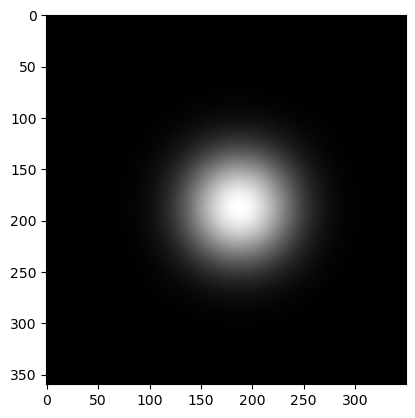

In [13]:
plt.imshow(diffuse_grid[100:460, 100:-190], cmap='gray')

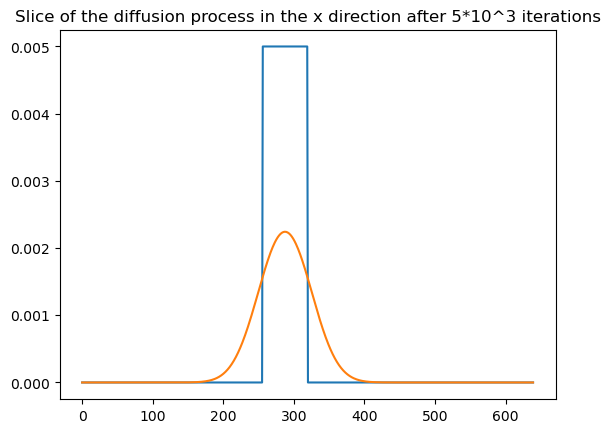

In [15]:
grid_shape = (640, 640)
grid = init_grid(grid_shape)
diffuse_grid_x = diffuse_grid[300,:]
x = torch.arange(0, diffuse_grid_x.shape[0])
plt.title('Slice of the diffusion process in the x direction after 5*10^3 iterations')
plt.plot(x, grid[300,:])
plt.plot(x, diffuse_grid_x)